In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter1d

pd.set_option('display.max_columns', None)

### Function Definition

In [2]:
# Quaternion to Spherical Coord
def q2s(row):
    result = {}
    num_joints = len([col for col in row.index if col.endswith('x')])

    for jointNum in range(0, num_joints):
        x, y, z, w = row[f"b{jointNum}x"], row[f"b{jointNum}y"], row[f"b{jointNum}z"], row[f"b{jointNum}w"]

        # Calcutate
        fnorm = np.sqrt(x**2 + y**2 + z**2)
        theta_r = np.arcsin(z / fnorm)
        phi_r= np.arctan2(y / fnorm, -x / fnorm)
        theta_d = theta_r * 180 / np.pi
        phi_d = phi_r * 180 / np.pi
        
        axis_x = np.cos(theta_r) * np.cos(phi_r)
        axis_y = np.cos(theta_r) * np.sin(phi_r)
        axis_z = np.sin(theta_r)      
        angle = 2 * np.arccos(w)

        # Store the results
        result.update({
            # Quaternion
            f'b{jointNum}x': x,
            f'b{jointNum}y': y,
            f'b{jointNum}z': z,
            f'b{jointNum}w': w,

            # Spherical coordinate
            f'b{jointNum}_fnorm': fnorm,
            f'b{jointNum}_theta_r': theta_r,
            f'b{jointNum}_phi_r': phi_r,
            f'b{jointNum}_theta_d': theta_d,
            f'b{jointNum}_phi_d': phi_d,
            f'b{jointNum}_axis_x': axis_x,
            f'b{jointNum}_axis_y': axis_y,
            f'b{jointNum}_axis_z': axis_z,
            f'b{jointNum}_angle': angle
        })

    return pd.Series(result)

In [3]:
# 전체 프레임 각 plot
def Angle_plot(dataFrame, jointNum, gesture):
    plt.figure(figsize=(20, 12))
    plt.grid(True, which='both', axis='both', linestyle='--')
    plt.plot(dataFrame[f'b{jointNum}_{gesture}_r'])
    plt.xticks(np.arange(0, len(dataFrame), step=10))
    plt.show()

In [4]:
# 일부 범위 각 plot
def Angle_plot2(dataFrame, jointNum, gesture, start=0, end=None):
    plt.figure(figsize=(20, 12))
    plt.plot(dataFrame[f'b{jointNum}_{gesture}_r'][start:end+1])
    plt.grid(True, which='both', axis='x', linestyle='--')
    plt.xticks(np.arange(start+1, end, step=5))
    plt.show()

In [5]:
# 전체 프레임 각속도 plot
def AV_plot(dataFrame, jointNum, gesture, sigma=2):
    transformed_df = dataFrame.apply(q2s, axis=1)

    rtheta_col = f'b{jointNum}_theta_r'
    rphi_col = f'b{jointNum}_phi_r'
    
    if gesture == 'theta':
        y = [transformed_df[rtheta_col].iloc[i] - transformed_df[rtheta_col].iloc[i - 1] for i in range(1, len(transformed_df))]
    if gesture == 'phi':
        y = [transformed_df[rphi_col].iloc[i] - transformed_df[rphi_col].iloc[i - 1] for i in range(1, len(transformed_df))]

    y_smooth = gaussian_filter1d(y, sigma=sigma)

    # Plot
    plt.figure(figsize=(20, 12))
    plt.plot(y, label='Original')
    plt.plot(y_smooth, label='Smoothed (Gaussian)', color='red')
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
    plt.grid(True, which='both', axis='x', linestyle='--')
    plt.legend()
    plt.xticks(np.arange(0, len(y), step=10))
    plt.show()

In [6]:
# 일부 범위 각속도 plot
def AV_plot2(dataFrame, jointNum, gesture, sigma=2, start=0, end=None):
    transformed_df = dataFrame.apply(q2s, axis=1)

    rtheta_col = f'b{jointNum}_theta_r'
    rphi_col = f'b{jointNum}_phi_r'
    
    if end is None:
        end = len(transformed_df)
    
    if gesture == 'theta':
        y = [transformed_df[rtheta_col].iloc[i] - transformed_df[rtheta_col].iloc[i - 1] for i in range(start + 1, end)]
    elif gesture == 'phi':
        y = [transformed_df[rphi_col].iloc[i] - transformed_df[rphi_col].iloc[i - 1] for i in range(start + 1, end)]
    else:
        raise ValueError("Invalid gesture. Choose 'theta' or 'phi'.")

    y_smooth = gaussian_filter1d(y, sigma=sigma)

    # Plot
    plt.figure(figsize=(20, 12))
    plt.plot(range(start + 1, end), y, label='Original')
    plt.plot(range(start + 1, end), y_smooth, label='Smoothed (Gaussian)', color='red')
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
    plt.grid(True, which='both', axis='x', linestyle='--')
    plt.legend()
    plt.xticks(np.arange(start+1, end, step=5))
    plt.show()

In [7]:
# Motion Edit Function


In [7]:
# Spherical Coord to Quaternion
def s2q(dataFrame1, dataFrame2, jointNum):
    # Degree theta, phi
    dataFrame1[f'b{jointNum}_theta_d'] = dataFrame1[f'b{jointNum}_theta_r'] * math.pi / 180
    dataFrame1[f'b{jointNum}_phi_d'] = dataFrame1[f'b{jointNum}_phi_r'] * math.pi / 180

    # New quaternion
    for i in range(len(dataFrame1)):
        theta = dataFrame1[f'b{jointNum}_theta_r'][i]
        phi = dataFrame1[f'b{jointNum}_phi_r'][i]
        angle = dataFrame1[f'b{jointNum}_angle'][i]

        dataFrame2[f'b{jointNum}x'][i] = -np.cos(theta) * np.cos(phi) * np.sin(angle / 2)
        dataFrame2[f'b{jointNum}y'][i] = np.cos(theta) * np.sin(phi) * np.sin(angle / 2)
        dataFrame2[f'b{jointNum}z'][i] = np.sin(theta) * np.sin(angle / 2)
        dataFrame2[f'b{jointNum}w'][i] = np.cos(angle / 2)

In [8]:
# To txt file
def dataFrame_to_txt(df, filename):
    frame_length = len(df)
    
    with open(filename, 'w') as file:
        file.write("FULLBODY\t1\n")
        file.write(f"Frames:\t{frame_length}\n")
        
        for index, row in df.iterrows():
            row_str = '\t'.join(map(str, row.values))
            file.write(f"{row_str}\n")

### Read dataset

In [9]:
column_names = ["b0x", "b0y", "b0z", "b0w", 
                "b1x", "b1y", "b1z", "b1w", 
                "b2x", "b2y", "b2z", "b2w", 
                "b3x", "b3y", "b3z", "b3w", 
                "b4x", "b4y", "b4z", "b4w", 
                "b5x", "b5y", "b5z", "b5w", 
                "b6x", "b6y", "b6z", "b6w", 
                "b7x", "b7y", "b7z", "b7w", 
                "b8x", "b8y", "b8z", "b8w", 
                "b9x", "b9y", "b9z", "b9w"]

root = "C:/Users/Velab/Desktop/mocap/뒤로걷기/FB-Raw-Data-000-16546.txt"

df = pd.read_csv(root, sep="\t", skiprows=2, header=None, names=column_names)
df.head()

,b0x,b0y,b0z,b0w,b1x,b1y,b1z,b1w,b2x,b2y,b2z,b2w,b3x,b3y,b3z,b3w,b4x,b4y,b4z,b4w,b5x,b5y,b5z,b5w,b6x,b6y,b6z,b6w,b7x,b7y,b7z,b7w,b8x,b8y,b8z,b8w,b9x,b9y,b9z,b9w
0,0.464057,-0.493716,-0.347142,-0.648374,0.500466,0.490026,-0.468638,0.538319,0.467702,0.479548,-0.640559,0.375463,0.451126,0.514137,-0.417760,0.598017,0.708534,-0.292542,-0.596687,0.237408,0.403085,0.509427,-0.566634,0.506885,-0.510797,-0.465901,0.572163,-0.441195,0.511063,0.428926,0.131353,0.733201,-0.999774,0.002868,-0.003259,-0.020790,0.999299,0.008748,-0.006221,0.035864
1,0.464022,-0.493618,-0.347469,-0.648298,0.500336,0.489898,-0.469041,0.538204,0.467525,0.479522,-0.640757,0.375378,0.451037,0.514158,-0.417908,0.597963,0.708516,-0.292413,-0.596807,0.237321,0.403275,0.509101,-0.566959,0.506697,-0.510576,-0.465941,0.572377,-0.441130,0.510929,0.428930,0.131088,0.733339,-0.999773,0.002943,-0.003192,-0.020839,0.999298,0.008777,-0.006243,0.035879
2,0.463885,-0.493832,-0.347694,-0.648113,0.500709,0.488973,-0.469770,0.538063,0.467277,0.479750,-0.640716,0.375466,0.450830,0.514273,-0.417984,0.597968,0.708465,-0.292284,-0.596969,0.237225,0.402994,0.509206,-0.567026,0.506741,-0.510466,-0.466036,0.572491,-0.441009,0.510859,0.428969,0.131028,0.733376,-0.999773,0.002863,-0.003296,-0.020845,0.999298,0.008794,-0.006134,0.035896
3,0.463903,-0.493830,-0.347869,-0.648007,0.500869,0.488511,-0.470046,0.538092,0.467090,0.479921,-0.640635,0.375620,0.450639,0.514391,-0.418041,0.597970,0.708453,-0.292123,-0.597101,0.237126,0.403053,0.509125,-0.567106,0.506687,-0.510424,-0.465985,0.572700,-0.440840,0.510792,0.429026,0.130831,0.733424,-0.999774,0.002807,-0.003261,-0.020825,0.999298,0.008759,-0.006141,0.035909
4,0.463827,-0.493873,-0.348158,-0.647873,0.500868,0.487792,-0.470374,0.538459,0.466812,0.480014,-0.640748,0.375653,0.450460,0.514488,-0.418058,0.598009,0.708418,-0.291985,-0.597238,0.237055,0.402936,0.509102,-0.567167,0.506734,-0.510440,-0.465882,0.572980,-0.440566,0.510662,0.429217,0.130652,0.733436,-0.999777,0.002690,-0.003142,-0.020723,0.999297,0.008777,-0.006191,0.035919


### Q2S

In [10]:
result_df = df.apply(q2s, axis=1)
result_df.head()

,b0x,b0y,b0z,b0w,b0_fnorm,b0_theta_r,b0_phi_r,b0_theta_d,b0_phi_d,b0_axis_x,b0_axis_y,b0_axis_z,b0_angle,b1x,b1y,b1z,b1w,b1_fnorm,b1_theta_r,b1_phi_r,b1_theta_d,b1_phi_d,b1_axis_x,b1_axis_y,b1_axis_z,b1_angle,b2x,b2y,b2z,b2w,b2_fnorm,b2_theta_r,b2_phi_r,b2_theta_d,b2_phi_d,b2_axis_x,b2_axis_y,b2_axis_z,b2_angle,b3x,b3y,b3z,b3w,b3_fnorm,b3_theta_r,b3_phi_r,b3_theta_d,b3_phi_d,b3_axis_x,b3_axis_y,b3_axis_z,b3_angle,b4x,b4y,b4z,b4w,b4_fnorm,b4_theta_r,b4_phi_r,b4_theta_d,b4_phi_d,b4_axis_x,b4_axis_y,b4_axis_z,b4_angle,b5x,b5y,b5z,b5w,b5_fnorm,b5_theta_r,b5_phi_r,b5_theta_d,b5_phi_d,b5_axis_x,b5_axis_y,b5_axis_z,b5_angle,b6x,b6y,b6z,b6w,b6_fnorm,b6_theta_r,b6_phi_r,b6_theta_d,b6_phi_d,b6_axis_x,b6_axis_y,b6_axis_z,b6_angle,b7x,b7y,b7z,b7w,b7_fnorm,b7_theta_r,b7_phi_r,b7_theta_d,b7_phi_d,b7_axis_x,b7_axis_y,b7_axis_z,b7_angle,b8x,b8y,b8z,b8w,b8_fnorm,b8_theta_r,b8_phi_r,b8_theta_d,b8_phi_d,b8_axis_x,b8_axis_y,b8_axis_z,b8_angle,b9x,b9y,b9z,b9w,b9_fnorm,b9_theta_r,b9_phi_r,b9_theta_d,b9_phi_d,b9_axis_x,b9_axis_y,b9_axis_z,b9_angle
0,0.464057,-0.493716,-0.347142,-0.648374,0.761323,-0.473464,-2.325238,-27.127513,-133.226310,-0.609541,-0.648498,-0.455972,4.552486,0.500466,0.490026,-0.468638,0.538319,0.842742,-0.589671,2.366734,-33.785650,135.603888,-0.593855,0.581467,-0.556087,2.004710,0.467702,0.479548,-0.640559,0.375463,0.926837,-0.763042,2.343689,-43.719110,134.283515,-0.504621,0.517403,-0.691123,2.371800,0.451126,0.514137,-0.417760,0.598017,0.801483,-0.548296,2.291008,-31.415048,131.265112,-0.562864,0.641482,-0.521234,1.859543,0.708534,-0.292542,-0.596687,0.237408,0.971410,-0.661433,-2.750029,-37.897343,-157.565077,-0.729387,-0.301152,-0.614249,2.662199,0.403085,0.509427,-0.566634,0.506885,0.862014,-0.717280,2.240180,-41.097141,128.352868,-0.467609,0.590973,-0.657338,2.078458,-0.510797,-0.465901,0.572163,-0.441195,0.897412,0.691340,-0.739463,39.610875,-42.368130,0.569189,-0.519161,0.637570,4.055452,0.511063,0.428926,0.131353,0.733201,0.680012,0.194385,2.443354,11.137415,139.993867,-0.751550,0.630762,0.193163,1.495558,-0.999774,0.002868,-0.003259,-0.020790,0.999783,-0.003260,0.002869,-0.186791,0.164356,0.999991,0.002869,-0.003260,3.183177,0.999299,0.008748,-0.006221,0.035864,0.999357,-0.006225,3.132839,-0.356649,179.498434,-0.999942,0.008754,-0.006225,3.069849
1,0.464022,-0.493618,-0.347469,-0.648298,0.761387,-0.473904,-2.325299,-27.152687,-133.229829,-0.609443,-0.648314,-0.456363,4.552286,0.500336,0.489898,-0.469041,0.538204,0.842814,-0.590189,2.366735,-33.815316,135.603929,-0.593649,0.581265,-0.556518,2.004983,0.467525,0.479522,-0.640757,0.375378,0.926871,-0.763303,2.343527,-43.734030,134.274227,-0.504412,0.517356,-0.691312,2.371984,0.451037,0.514158,-0.417908,0.597963,0.801523,-0.548482,2.290890,-31.425675,131.258347,-0.562725,0.641476,-0.521392,1.859678,0.708516,-0.292413,-0.596807,0.237321,0.971431,-0.661573,-2.750176,-37.905314,-157.573477,-0.729353,-0.301013,-0.614358,2.662378,0.403275,0.509101,-0.566959,0.506697,0.862124,-0.717669,2.240721,-41.119432,128.383858,-0.467769,0.590520,-0.657631,2.078894,-0.510576,-0.465941,0.572377,-0.441130,0.897443,0.691621,-0.739722,39.626949,-42.382925,0.568923,-0.519187,0.637786,4.055307,0.510929,0.428930,0.131088,0.733339,0.679863,0.194031,2.443220,11.117132,139.986205,-0.751518,0.630907,0.192815,1.495152,-0.999773,0.002943,-0.003192,-0.020839,0.999782,-0.003193,0.002943,-0.182941,0.168633,0.999991,0.002943,-0.003193,3.183274,0.999298,0.008777,-0.006243,0.035879,0.999356,-0.006247,3.132810,-0.357942,179.496791,-0.999942,0.008782,-0.006247,3.069820
2,0.463885,-0.493832,-0.347694,-0.648113,0.761545,-0.474129,-2.324936,-27.165616,-133.208993,-0.609137,-0.648461,-0.456564,4.551801,0.500709,0.488973,-0.469770,0.538063,0.842904,-0.591158,2.368052,-33.870863,135.679402,-0.594028,0.580105,-0.557323,2.005318,0.467277,0.479750,-0.640716,0.375466,0.926836,-0.763278,2.343025,-43.732617,134.245419,-0.504164,0.517621,-0.691294,2.371794,0.450830,0.514273,-0.417984,0.597968,0.801520,-0.548595,2.290552,-31.

In [11]:
result_df[145:165]

,b0x,b0y,b0z,b0w,b0_fnorm,b0_theta_r,b0_phi_r,b0_theta_d,b0_phi_d,b0_axis_x,b0_axis_y,b0_axis_z,b0_angle,b1x,b1y,b1z,b1w,b1_fnorm,b1_theta_r,b1_phi_r,b1_theta_d,b1_phi_d,b1_axis_x,b1_axis_y,b1_axis_z,b1_angle,b2x,b2y,b2z,b2w,b2_fnorm,b2_theta_r,b2_phi_r,b2_theta_d,b2_phi_d,b2_axis_x,b2_axis_y,b2_axis_z,b2_angle,b3x,b3y,b3z,b3w,b3_fnorm,b3_theta_r,b3_phi_r,b3_theta_d,b3_phi_d,b3_axis_x,b3_axis_y,b3_axis_z,b3_angle,b4x,b4y,b4z,b4w,b4_fnorm,b4_theta_r,b4_phi_r,b4_theta_d,b4_phi_d,b4_axis_x,b4_axis_y,b4_axis_z,b4_angle,b5x,b5y,b5z,b5w,b5_fnorm,b5_theta_r,b5_phi_r,b5_theta_d,b5_phi_d,b5_axis_x,b5_axis_y,b5_axis_z,b5_angle,b6x,b6y,b6z,b6w,b6_fnorm,b6_theta_r,b6_phi_r,b6_theta_d,b6_phi_d,b6_axis_x,b6_axis_y,b6_axis_z,b6_angle,b7x,b7y,b7z,b7w,b7_fnorm,b7_theta_r,b7_phi_r,b7_theta_d,b7_phi_d,b7_axis_x,b7_axis_y,b7_axis_z,b7_angle,b8x,b8y,b8z,b8w,b8_fnorm,b8_theta_r,b8_phi_r,b8_theta_d,b8_phi_d,b8_axis_x,b8_axis_y,b8_axis_z,b8_angle,b9x,b9y,b9z,b9w,b9_fnorm,b9_theta_r,b9_phi_r,b9_theta_d,b9_phi_d,b9_axis_x,b9_axis_y,b9_axis_z,b9_angle
145,0.790714,-0.095737,-0.593006,-0.118108,0.993001,-0.639988,-3.021102,-36.668618,-173.096423,-0.796287,-0.096412,-0.597186,3.378361,-0.024348,0.682829,0.028083,0.729633,0.683840,0.041078,1.535154,2.353590,87.957839,0.035605,0.998522,0.041066,1.506022,0.038703,0.777085,-0.095167,0.620955,0.783847,-0.121710,1.620560,-6.973461,92.851252,-0.049375,0.991374,-0.121410,1.801672,-0.137780,0.668696,0.122922,0.720245,0.693720,0.178133,1.367597,10.206274,78.357547,0.198610,0.963928,0.177193,1.533282,0.305015,0.234321,-0.611740,0.691255,0.722611,-1.009506,2.486527,-57.840453,142.467529,-0.422101,0.324270,-0.846569,1.615144,-0.032256,0.750167,-0.034701,0.659548,0.751662,-0.046182,1.527825,-2.646019,87.537911,0.042913,0.998012,-0.046165,1.701158,-0.049919,-0.739462,0.052165,-0.669315,0.742979,0.070268,-1.503392,4.026055,-86.137990,0.067188,-0.995267,0.070210,4.608166,-0.118432,0.196762,0.432097,0.872096,0.489336,1.082276,1.028977,62.009826,58.956061,0.242026,0.402100,0.883028,1.022654,-0.999772,0.002557,-0.003513,-0.020900,0.999781,-0.003513,0.002558,-0.201306,0.146557,0.999991,0.002558,-0.003513,3.183395,0.999267,0.009198,-0.005503,0.036737,0.999324,-0.005507,3.132389,-0.315539,179.472644,-0.999942,0.009204,-0.005507,3.068101
146,0.790710,-0.095883,-0.593025,-0.117919,0.993023,-0.639995,-3.020920,-36.669028,-173.085948,-0.796266,-0.096557,-0.597192,3.377981,-0.024973,0.683167,0.029546,0.729237,0.684261,0.043193,1.534259,2.474784,87.906541,0.036496,0.998401,0.043180,1.507180,0.038516,0.777756,-0.094627,0.620208,0.784437,-0.120925,1.620278,-6.928486,92.835076,-0.049100,0.991482,-0.120630,1.803577,-0.138011,0.668508,0.123349,0.720302,0.693661,0.178774,1.367210,10.242998,78.335372,0.198960,0.963739,0.177823,1.533117,0.305109,0.234067,-0.611425,0.691578,0.722301,-1.009368,2.487200,-57.832532,142.506072,-0.422412,0.324057,-0.846496,1.614250,-0.032382,0.750364,-0.034608,0.659324,0.751859,-0.046046,1.527668,-2.638220,87.528938,0.043069,0.998011,-0.046029,1.701754,-0.049446,-0.739560,0.051779,-0.669272,0.743017,0.069744,-1.504037,3.996051,-86.174965,0.066548,-0.995347,0.069688,4.608050,-0.118334,0.196639,0.432061,0.872155,0.489231,1.082523,1.029067,62.023971,58.961188,0.241878,0.401935,0.883144,1.022413,-0.999772,0.002558,-0.003492,-0.020907,0.999781,-0.003492,0.002559,-0.200094,0.146607,0.999991,0.002559,-0.003492,3.183410,0.999267,0.009221,-0.005501,0.036744,0.999325,-0.005504,3.132365,-0.315375,179.471296,-0.999942,0.009227,-0.005504,3.068089
147,0.790687,-0.095039,-0.593230,-0.117725,0.993046,-0.640235,-3.021968,-36.682787,-173.146029,-0.796224,-0.095705,-0.597384,3.377590,-0.024844,0.683750,0.030018,0.728676,0.684859,0.043845,1.534477,2.512105,87.919045,0.036277,0.998380,0.043830,1.508819,0.038021,0.777297,-0.093827,0.620936,0.783862,-0.119986,1.619672,-6.874672,92.800348,-0.048505,0.991625,-0.119698,1.801720,-0.138094,0.669042,0.123858,0.719702,0.694282,0.179357,1.367249,10.276413,78.337609,0.198902,0.963645,0.178397,1.

In [12]:
df[145:165]

,b0x,b0y,b0z,b0w,b1x,b1y,b1z,b1w,b2x,b2y,b2z,b2w,b3x,b3y,b3z,b3w,b4x,b4y,b4z,b4w,b5x,b5y,b5z,b5w,b6x,b6y,b6z,b6w,b7x,b7y,b7z,b7w,b8x,b8y,b8z,b8w,b9x,b9y,b9z,b9w
145,0.790714,-0.095737,-0.593006,-0.118108,-0.024348,0.682829,0.028083,0.729633,0.038703,0.777085,-0.095167,0.620955,-0.137780,0.668696,0.122922,0.720245,0.305015,0.234321,-0.611740,0.691255,-0.032256,0.750167,-0.034701,0.659548,-0.049919,-0.739462,0.052165,-0.669315,-0.118432,0.196762,0.432097,0.872096,-0.999772,0.002557,-0.003513,-0.020900,0.999267,0.009198,-0.005503,0.036737
146,0.790710,-0.095883,-0.593025,-0.117919,-0.024973,0.683167,0.029546,0.729237,0.038516,0.777756,-0.094627,0.620208,-0.138011,0.668508,0.123349,0.720302,0.305109,0.234067,-0.611425,0.691578,-0.032382,0.750364,-0.034608,0.659324,-0.049446,-0.739560,0.051779,-0.669272,-0.118334,0.196639,0.432061,0.872155,-0.999772,0.002558,-0.003492,-0.020907,0.999267,0.009221,-0.005501,0.036744
147,0.790687,-0.095039,-0.593230,-0.117725,-0.024844,0.683750,0.030018,0.728676,0.038021,0.777297,-0.093827,0.620936,-0.138094,0.669042,0.123858,0.719702,0.305441,0.233658,-0.610846,0.692082,-0.032382,0.749842,-0.033473,0.659975,-0.049108,-0.740017,0.052407,-0.668742,-0.119080,0.196451,0.431553,0.872347,-0.999772,0.002559,-0.003495,-0.020920,0.999267,0.009206,-0.005509,0.036749
148,0.790114,-0.094708,-0.594149,-0.117207,-0.025086,0.684652,0.030794,0.727787,0.038488,0.776255,-0.093697,0.622228,-0.138902,0.669885,0.124599,0.718634,0.305926,0.233520,-0.610420,0.692290,-0.032897,0.749009,-0.032155,0.660961,-0.050914,-0.740171,0.054646,-0.668257,-0.119695,0.196533,0.431476,0.872282,-0.999772,0.002567,-0.003503,-0.020916,0.999267,0.009202,-0.005507,0.036752
149,0.790105,-0.094677,-0.594217,-0.116948,-0.024981,0.685109,0.031378,0.727335,0.038066,0.775898,-0.092512,0.622876,-0.139147,0.670631,0.124885,0.717841,0.306406,0.233628,-0.610345,0.692107,-0.032978,0.749176,-0.031610,0.660794,-0.051189,-0.740727,0.054595,-0.667625,-0.119593,0.196414,0.431344,0.872388,-0.999772,0.002564,-0.003517,-0.020925,0.999267,0.009202,-0.005534,0.036754
150,0.790286,-0.095529,-0.594007,-0.116090,-0.024404,0.684795,0.031772,0.727634,0.038321,0.777116,-0.092397,0.621357,-0.138300,0.670740,0.124512,0.717967,0.306815,0.233483,-0.610460,0.691874,-0.032192,0.749381,-0.032263,0.660568,-0.051576,-0.740962,0.053975,-0.667385,-0.119081,0.196200,0.431556,0.872402,-0.999772,0.002566,-0.003534,-0.020919,0.999268,0.009213,-0.005524,0.036728
151,0.790397,-0.096064,-0.593815,-0.115880,-0.024141,0.684090,0.032459,0.728275,0.038792,0.777641,-0.092020,0.620727,-0.137504,0.670703,0.124082,0.718230,0.306945,0.233253,-0.610664,0.691714,-0.032352,0.750095,-0.032341,0.659747,-0.051721,-0.740964,0.053573,-0.667403,-0.118456,0.196321,0.432097,0.872192,-0.999771,0.002546,-0.003528,-0.020936,0.999267,0.009217,-0.005534,0.036734
152,0.790247,-0.096720,-0.593841,-0.116220,-0.023802,0.683786,0.032872,0.728553,0.039480,0.778178,-0.092498,0.619939,-0.136488,0.670925,0.123649,0.718291,0.307249,0.232885,-0.610729,0.691645,-0.031686,0.750420,-0.033040,0.659374,-0.052414,-0.740982,0.054093,-0.667287,-0.118469,0.196485,0.432257,0.872074,-0.999772,0.002521,-0.003515,-0.020931,0.999267,0.009201,-0.005526,0.036755
153,0.789762,-0.096907,-0.594418,-0.116418,-0.023318,0.683231,0.033266,0.729072,0.040894,0.777895,-0.092681,0.620175,-0.135224,0.670859,0.123098,0.718686,0.306353,0.232726,-0.611737,0.691205,-0.031428,0.750405,-0.032860,0.659413,-0.053696,-0.741032,0.055722,-0.666996,-0.118907,0.196711,0.432303,0.871940,-0.999772,0.002512,-0.003539,-0.020921,0.999267,0.009220,-0.005515,0.036756
154,0.789117,-0.097423,-0.595065,-0.117047,-0.023293,0.682843,0.033508,0.729424,0.042770,0.777397,-0.094140,0.620453,-0.133753,0.671021,0.122173,0.718968,0.305774,0.232289,-0.612950,0.690534,-0.031248,0.750258,-0.032397,0.659612,-0.054825,-0.741065,0.057005,-0.666758,-0.119216,0.196850,0.432276,0.871880,-0.999772,0.002513,-0.003547,-0.020927,0.999267,0.009215,-0.005518,0.036756


### Angle (Theta, Phi)

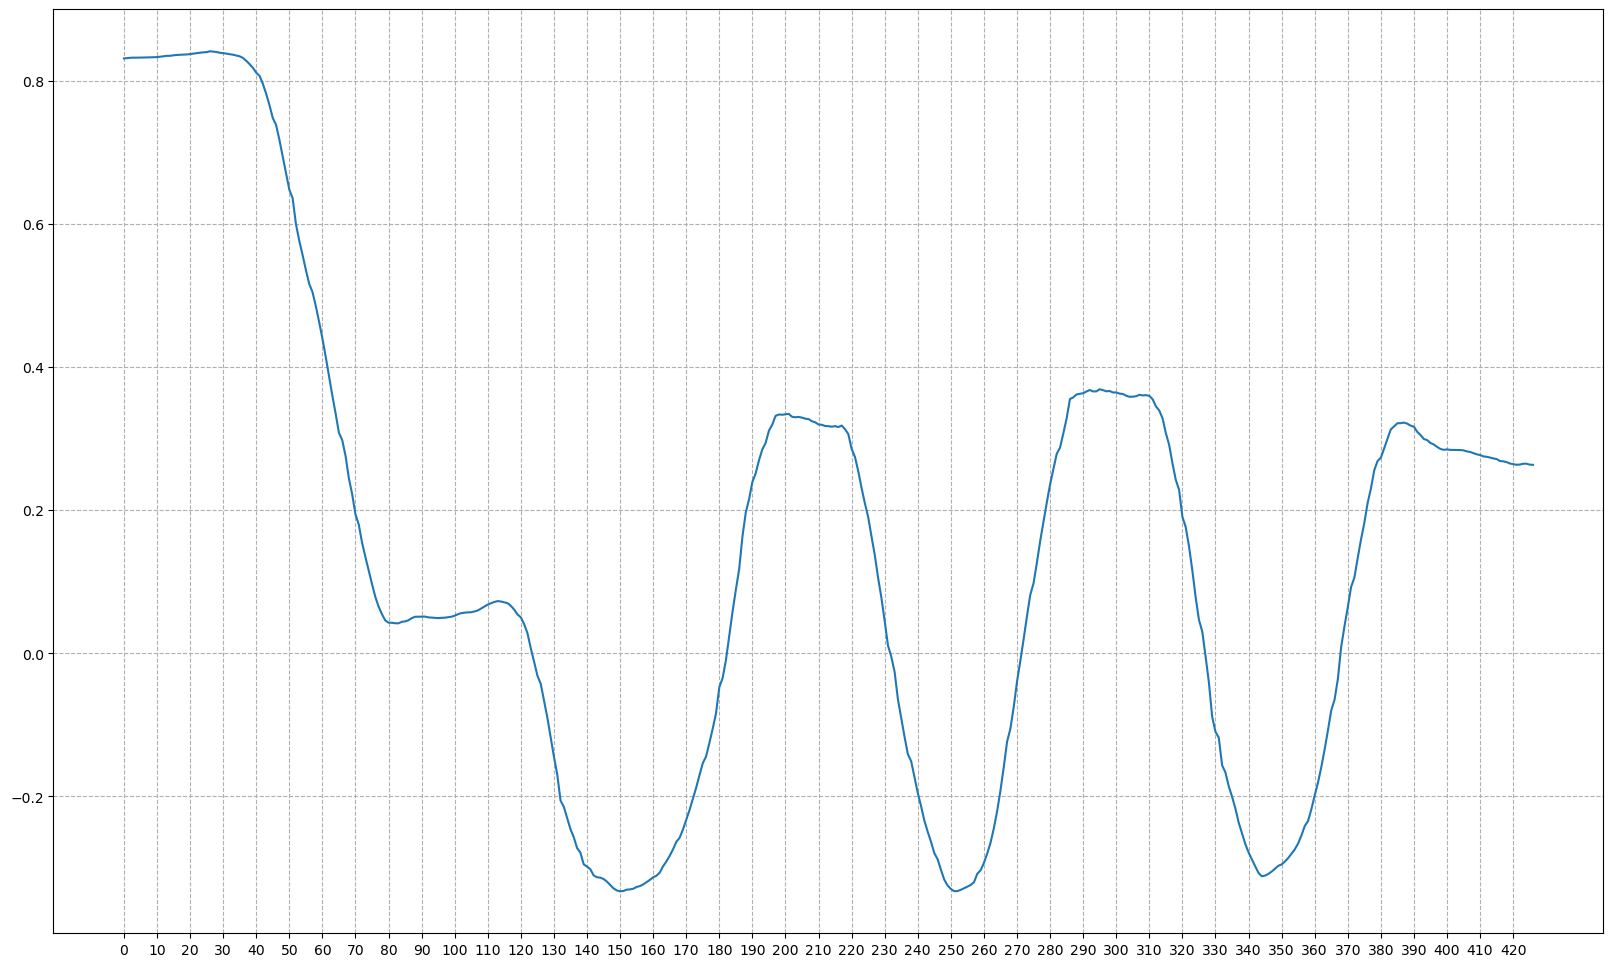

In [14]:
Angle_plot(result_df, jointNum=3, gesture='theta')

### Angular Velocity

- 편집할 조인트와 바디 제스처를 선택

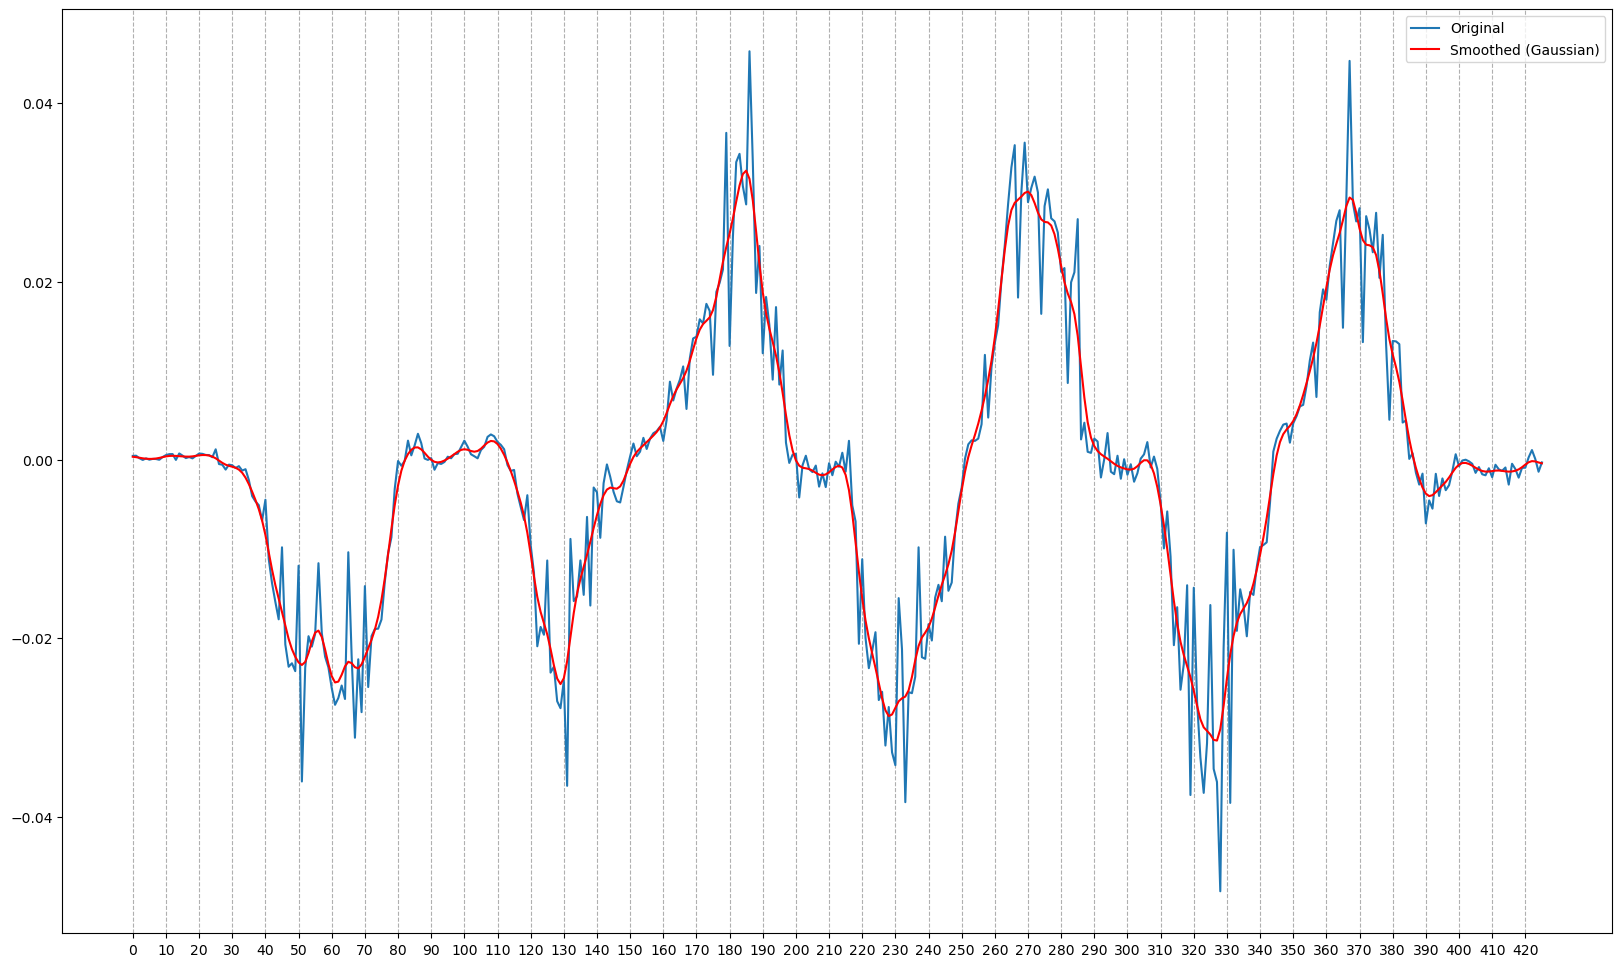

In [15]:
AV_plot(df, jointNum=3, gesture='theta')

### Range selection

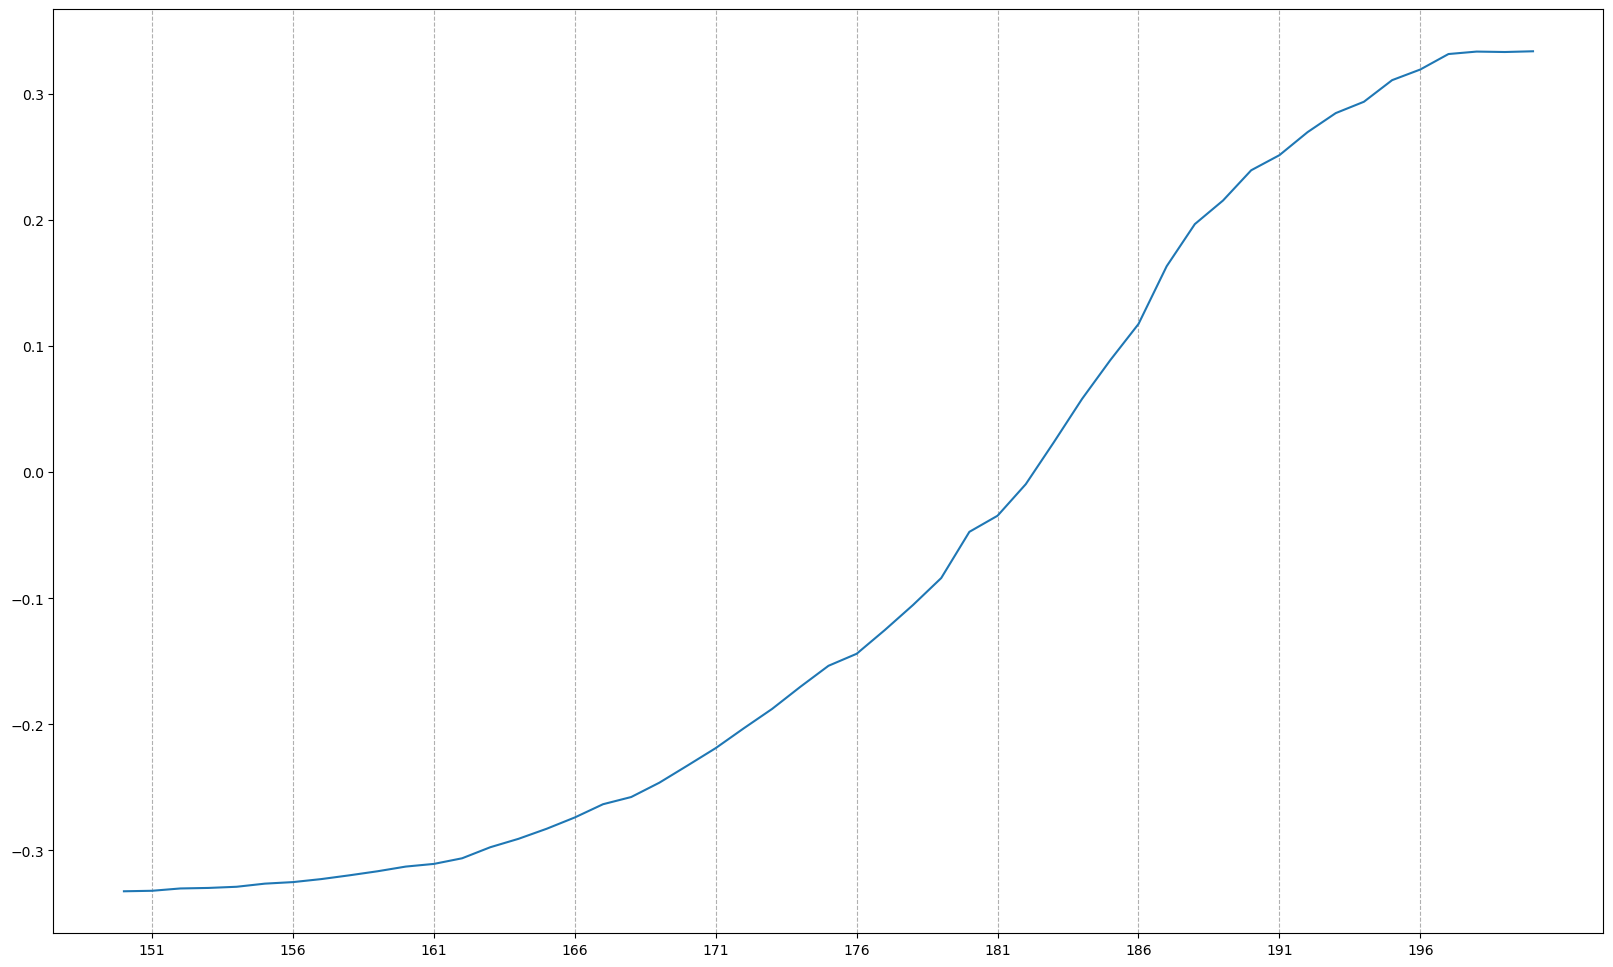

In [16]:
# Angle
Angle_plot2(result_df, jointNum=3, gesture='theta', start=150, end=200)

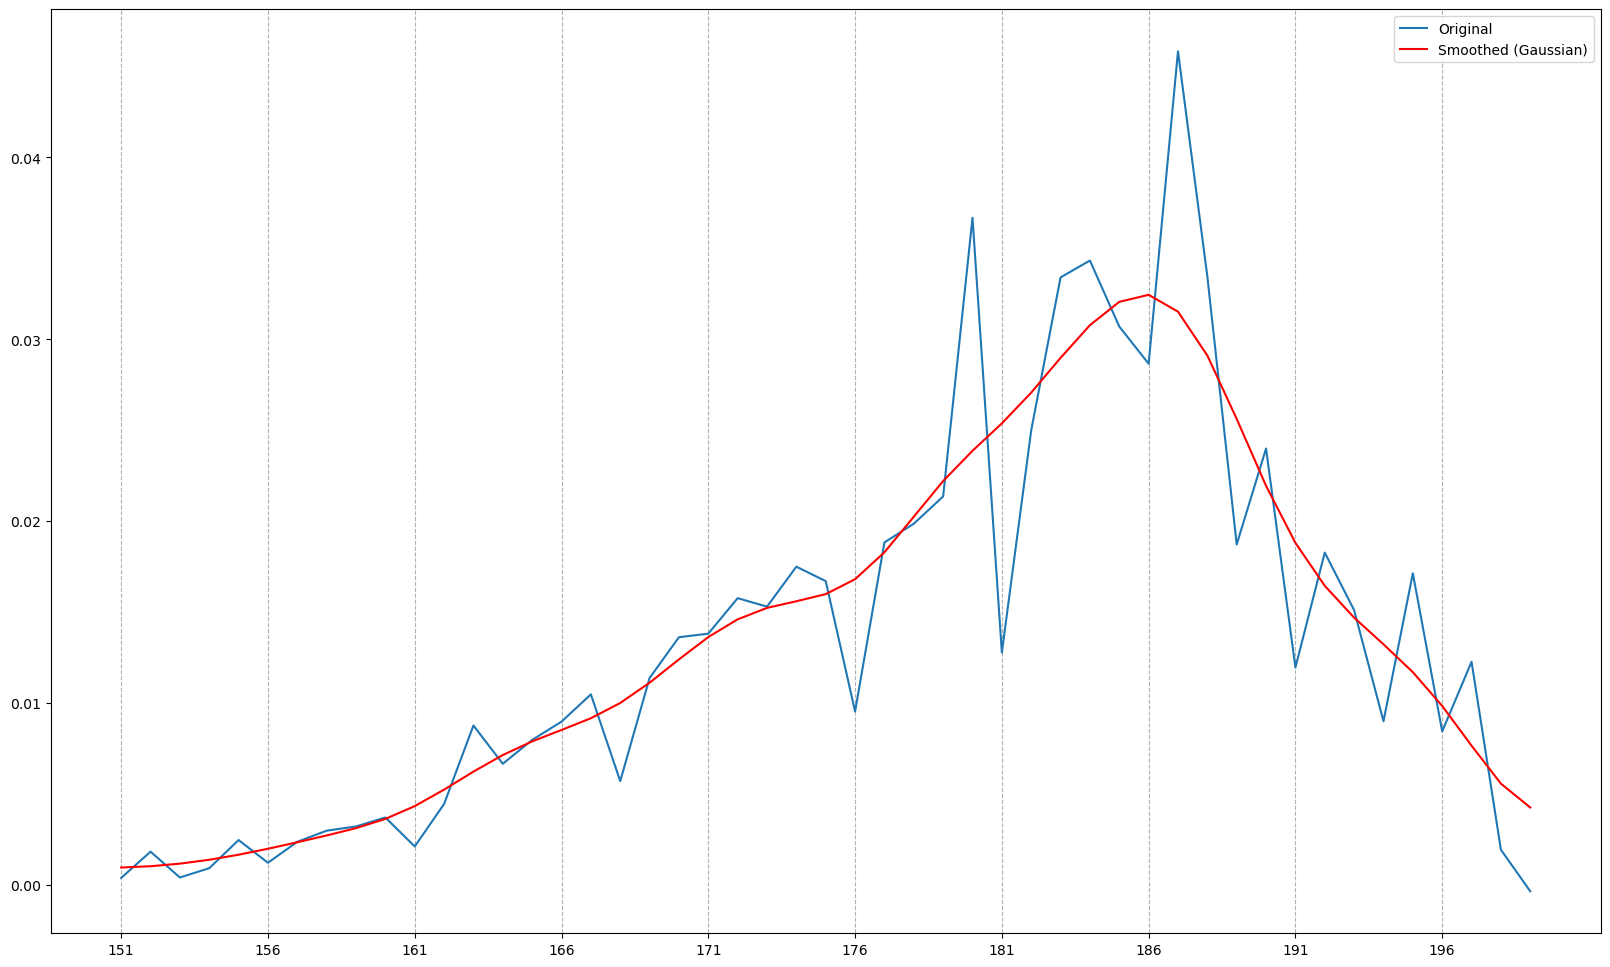

In [17]:
# Angular velocity
AV_plot2(df, jointNum=3, gesture='theta', start=150, end=200)

### Motion editing

In [18]:
# Before editing
result_df['b3_theta_r'][150:201].head()

150   -0.332468
151   -0.332073
152   -0.330235
153   -0.329817
154   -0.328887
Name: b3_theta_r, dtype: float64

In [222]:
# Motion Editing
result_df['b3_theta_r'][150:155] = 0

In [223]:
# After editing
result_df['b3_theta_r'][150:201].head(10)

150    0.000000
151    0.000000
152    0.000000
153    0.000000
154    0.000000
155   -0.326412
156   -0.325184
157   -0.322804
158   -0.319813
159   -0.316590
Name: b3_theta_r, dtype: float64

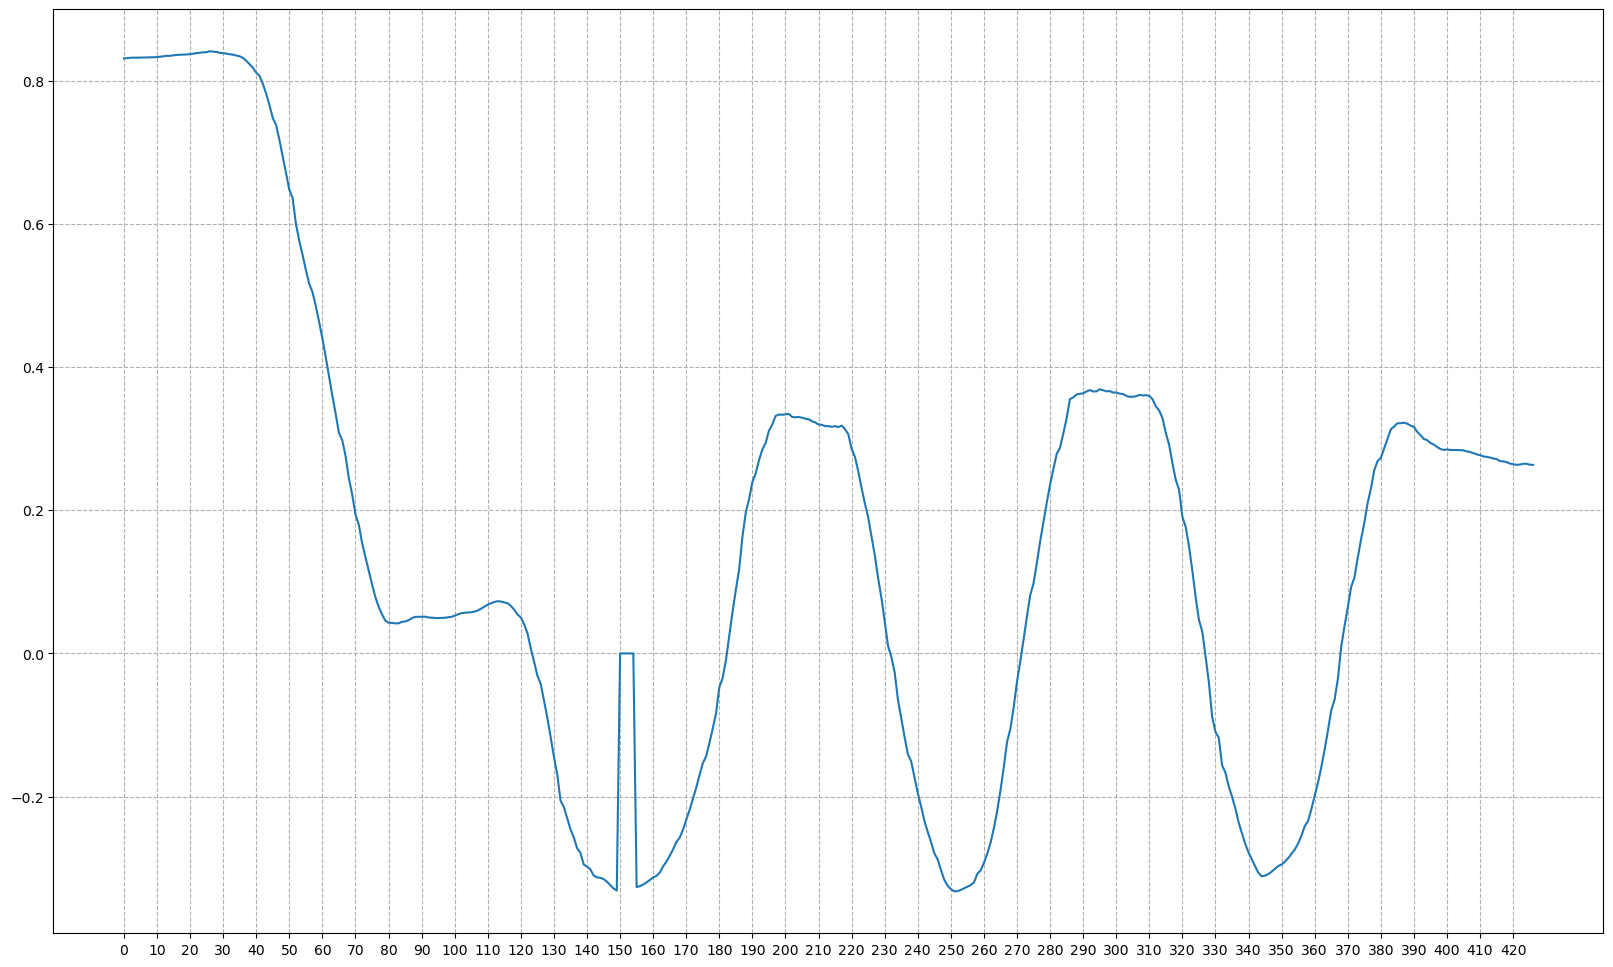

In [237]:
Angle_plot(result_df, jointNum=3, gesture='theta')

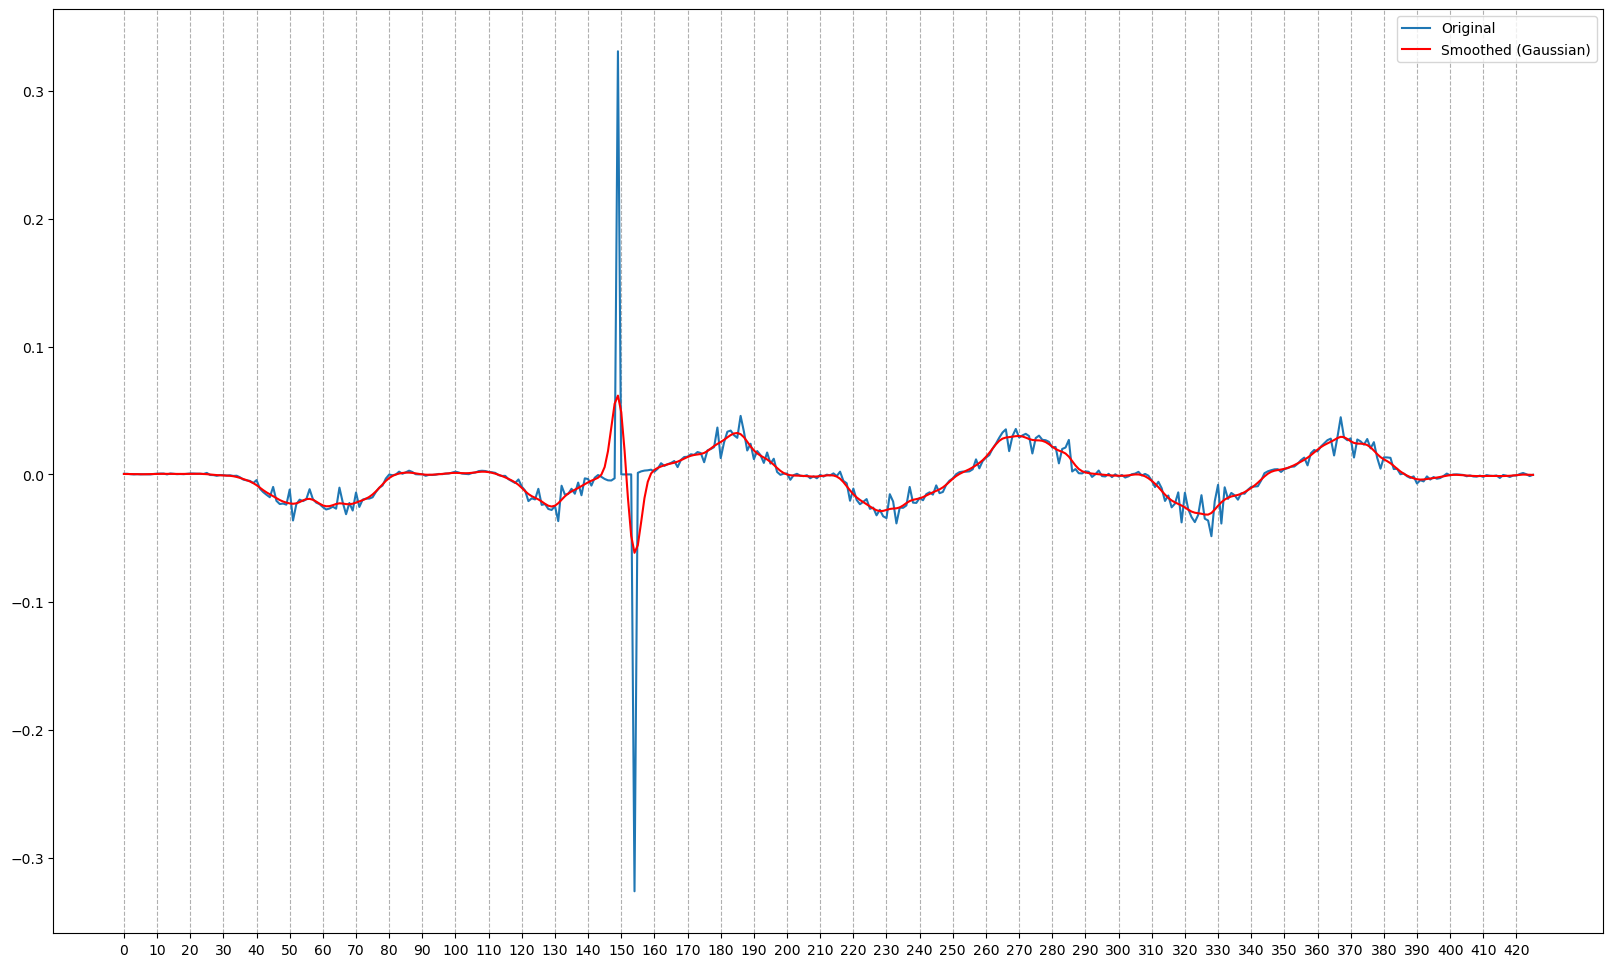

In [236]:
AV_plot(df, jointNum=3, gesture='theta')

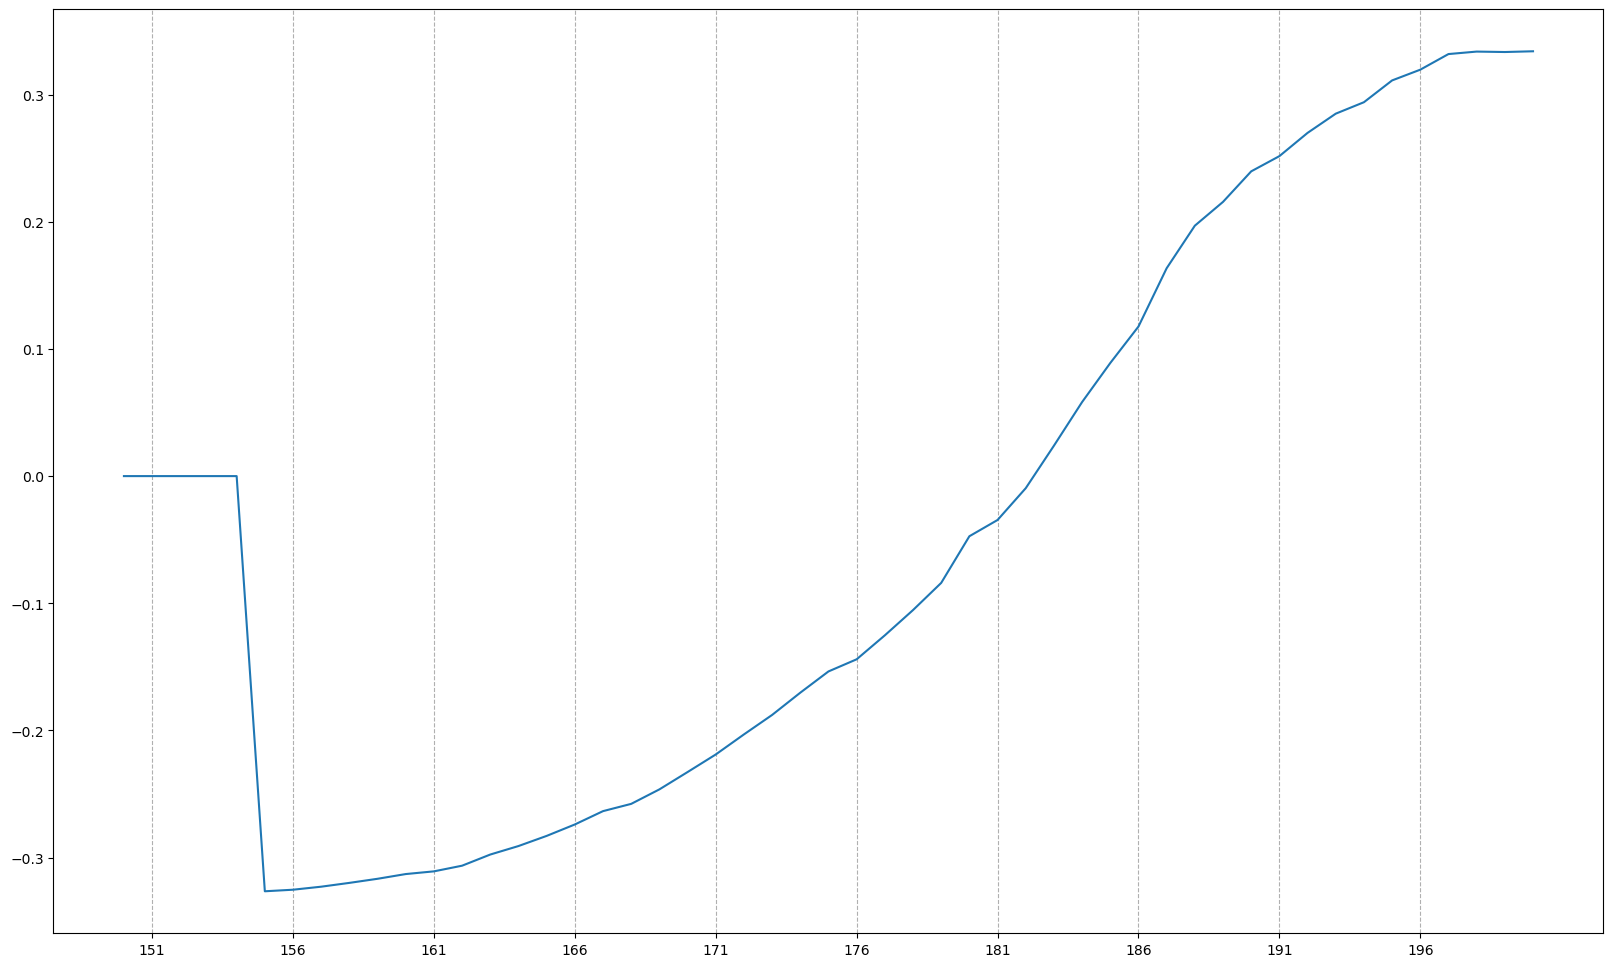

In [238]:
# Angle
Angle_plot2(result_df, jointNum=3, gesture='theta', start=150, end=200)

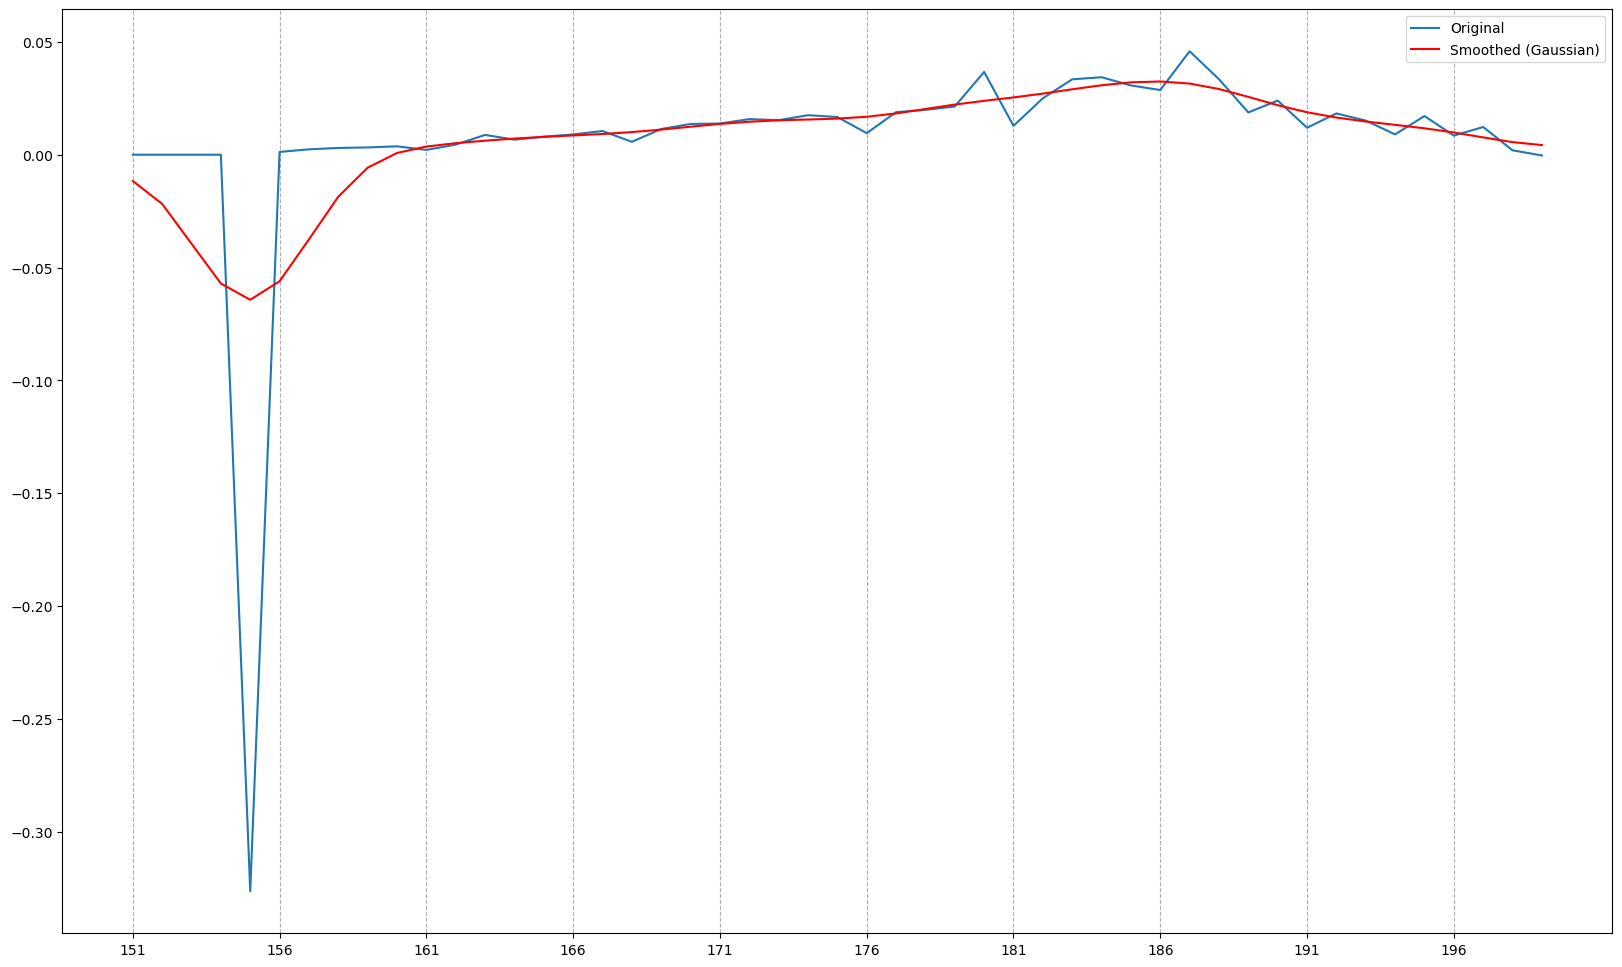

In [239]:
# Angular velocity
AV_plot2(df, jointNum=3, gesture='theta', start=150, end=200)

### S2Q

- 수정 후의 edit 변수 (degree theta, degree phi) 를 result_df에 저장.
- result_df에 들어간 degree theta, degree phi를 이용해 쿼터니언 변환.
- result_df에 들어간 새로운 쿼터니언을 df의 맞는 joint, 프레임 인덱스에 삽입.
- 최종 결과는 df.

In [230]:
s2q(result_df, df, 3)

### To Text File

In [234]:
dataFrame_to_txt(df, 'D:/PoseTrack19/src/out/build/SkeletonData/20241030/motion_edit.txt')